In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader 
import torch.optim as optim
import numpy as np 
import matplotlib.pyplot as plt 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

/home/fashr003/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


#### 1. (3 pts) Setup your code so that you can run multiple MNIST models for varying choices of k and p automatically, Specifically, you need two for loops (one for k and one for p) and within the loop, you call PyTorch/TensorFlow.

In [2]:
class ShallowNeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_units, dropout_prob):
        super(ShallowNeuralNetwork, self).__init__()
        self.W = nn.Parameter(torch.randn(hidden_units, input_size) * torch.sqrt(torch.tensor(2.0 / input_size)))  # He initialization
        self.V = nn.Parameter(torch.randn(output_size, hidden_units) * torch.sqrt(torch.tensor(2.0 / hidden_units)))  # He initialization
        self.dropout = nn.Dropout(p=1-dropout_prob)

    def forward(self, x):
        x = F.relu(torch.matmul(x, self.W.t()))             # ReLU  
        x = self.dropout(x)                                 # dropout
        x = F.softmax(torch.matmul(x, self.V.t()), dim=1)   # Softmax 
        return x

In [3]:
import torchvision.datasets as datasets 
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

train_images = train_dataset.data.float() /255.
#train_labels = F.one_hot(train_dataset.targets, num_classes=10).float().numpy()
train_labels = train_dataset.targets 


new_train_images = []
new_train_labels = []
for label in torch.unique(train_labels):
    indices = torch.nonzero(train_labels == label, as_tuple=False).squeeze()
    selected_indices = np.random.choice(indices, size=1000, replace=False)
    new_train_images.append(train_images[selected_indices])
    new_train_labels.append(train_labels[selected_indices])
train_images = torch.cat(new_train_images, dim=0) 
train_labels = torch.cat(new_train_labels, dim=0)

train_images = train_images.numpy()
train_labels = F.one_hot(train_labels, num_classes=10).float().numpy()

test_images = test_dataset.data.float() /255.
test_labels = F.one_hot(test_dataset.targets, num_classes=10).float().numpy()
  

train_images = train_images.reshape(train_images.shape[0],-1)
test_images = test_images.numpy().reshape(test_images.shape[0],-1)


In [4]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((10000, 784), (10000, 784), (10000, 10), (10000, 10))

In [5]:
train_dataset = TensorDataset(torch.from_numpy(train_images), torch.from_numpy(train_labels)) 
test_dataset = TensorDataset(torch.from_numpy(test_images), torch.from_numpy(test_labels)) 

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        predicted_onehot = F.one_hot(predicted, num_classes=10).float()
        #print(predicted_onehot, targets)
        total += targets.size(0)
        correct += (predicted_onehot == targets).all(dim=1).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    return train_loss, train_accuracy

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predicted_onehot = F.one_hot(predicted, num_classes=10).float()
            total += targets.size(0)
            correct += (predicted_onehot == targets).all(dim=1).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    return test_loss, test_accuracy

#### 2. (7 pts) Pick the width grid K = [1, 5, 10, 20, 40] and dropout grid P = [0.1, 0.5, 1.0]. Run MNIST models over these grids with Adam optimizer for 80 epochs. Store the test/train accuracy and loss. 

In [7]:
# Define parameters
input_size = 784
output_size = 10
hidden_units_list = [1, 5, 10, 20, 40]
dropout_prob_list = [0.1, 0.5, 1.0] 

In [9]:
results = []

for hidden_units in hidden_units_list:
    for dropout_prob in dropout_prob_list:
        print(f"Hidden Units: {hidden_units}, Dropout Prob: {dropout_prob} => ") 
        model = ShallowNeuralNetwork(input_size, output_size, hidden_units, dropout_prob)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 80
        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []
        for epoch in range(num_epochs):
            # Training
            train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            # Testing
            test_loss, test_accuracy = test(model, test_loader, criterion, device)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)
            print(f"({hidden_units}, {dropout_prob}) Epoch:{epoch}/{num_epochs}, train_loss:{train_loss:0.4f}, train_acc:{train_accuracy:0.3f}, test_loss:{test_loss:0.4f}, test_acc:{test_accuracy:0.3f}")
        
        result = {
            'hidden_units': hidden_units,
            'dropout_probability': dropout_prob,
            'train_loss': train_losses,
            'train_accuracy': train_accuracies,
            'test_loss': test_losses,
            'test_accuracy': test_accuracies 
        }
        results.append(result)
        

Hidden Units: 1, Dropout Prob: 0.1 => 
(1, 0.1) Epoch:0/80, train_loss:2.3026, train_acc:0.101, test_loss:2.3024, test_acc:0.097
(1, 0.1) Epoch:1/80, train_loss:2.3007, train_acc:0.102, test_loss:2.2950, test_acc:0.141
(1, 0.1) Epoch:2/80, train_loss:2.2976, train_acc:0.104, test_loss:2.2872, test_acc:0.156
(1, 0.1) Epoch:3/80, train_loss:2.2963, train_acc:0.106, test_loss:2.2884, test_acc:0.159
(1, 0.1) Epoch:4/80, train_loss:2.2974, train_acc:0.104, test_loss:2.2805, test_acc:0.161
(1, 0.1) Epoch:5/80, train_loss:2.2978, train_acc:0.105, test_loss:2.2834, test_acc:0.159
(1, 0.1) Epoch:6/80, train_loss:2.2957, train_acc:0.108, test_loss:2.2854, test_acc:0.164
(1, 0.1) Epoch:7/80, train_loss:2.2966, train_acc:0.106, test_loss:2.2820, test_acc:0.167
(1, 0.1) Epoch:8/80, train_loss:2.2964, train_acc:0.106, test_loss:2.2817, test_acc:0.163
(1, 0.1) Epoch:9/80, train_loss:2.2957, train_acc:0.107, test_loss:2.2774, test_acc:0.169
(1, 0.1) Epoch:10/80, train_loss:2.2969, train_acc:0.107, tes

#### 2. a) Fix p = 1.0 which is the case of “no dropout regularization”. Plot the test and training accuracy as a function of k. 

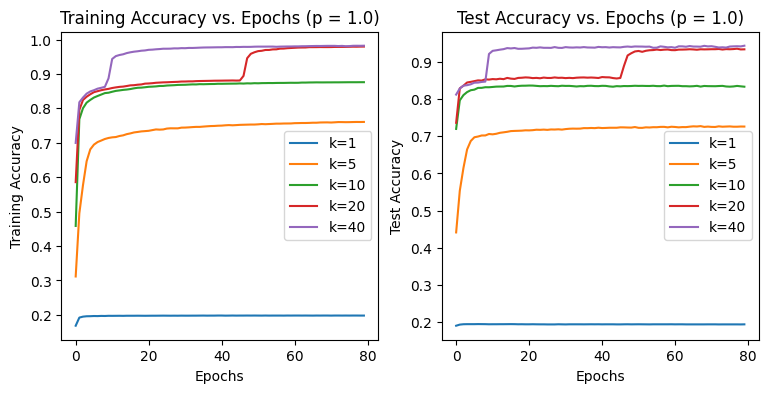

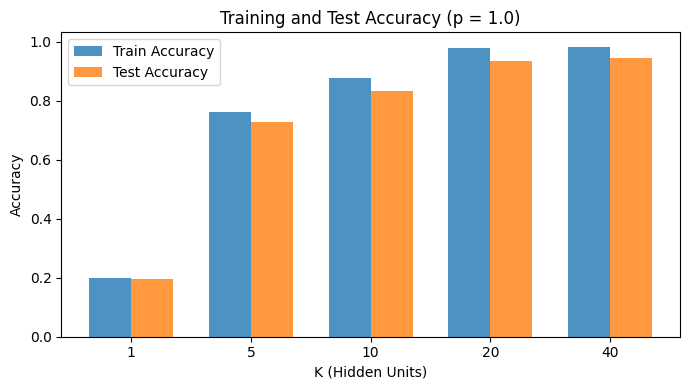

In [11]:
plt.figure(figsize=(9, 4))
a=plt.subplot(121)
for result in results:
    if result['dropout_probability'] == 1.0:
        #print(result['hidden_units'], result['train_accuracy'][-1])
        a.plot(result['train_accuracy'], label=f"k={result['hidden_units']}")

a.set_xlabel('Epochs')
a.set_ylabel('Training Accuracy')
a.set_title('Training Accuracy vs. Epochs (p = 1.0)')
a.legend()

b=plt.subplot(122)
for result in results:
    if result['dropout_probability'] == 1.0:
        #print(result['hidden_units'], result['test_accuracy'][-1])
        b.plot(result['test_accuracy'], label=f"k={result['hidden_units']}")

b.set_xlabel('Epochs')
b.set_ylabel('Test Accuracy')
b.set_title('Test Accuracy vs. Epochs (p = 1.0)')
b.legend()

plt.show() 


plt.figure(figsize=(7, 4))
bar_width = 0.35
opacity = 0.8

hidden_units = []
train_accuracy = []
test_accuracy = []

for result in results:
    if result['dropout_probability'] == 1.0:
        hidden_units.append(result['hidden_units'])
        train_accuracy.append(result['train_accuracy'][-1])
        test_accuracy.append(result['test_accuracy'][-1])

x = np.arange(len(hidden_units))

plt.bar(x - bar_width/2, train_accuracy, bar_width, alpha=opacity, label='Train Accuracy')
plt.bar(x + bar_width/2, test_accuracy, bar_width, alpha=opacity, label='Test Accuracy')

plt.xlabel('K (Hidden Units)')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy (p = 1.0)')
plt.xticks(x, hidden_units)  # Set the x-axis ticks to hidden_units
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**As k increases, does the performance improve? At what k, training accuracy becomes 100%?** 

Yes. As the number of hidden units increases, the performance also improves. I didn't get 100% accuracy within 80 epoch. However, I got 98.2% training accuracy and 94.4% test accuracy when k=40. 


#### 2. b) Plot the training accuracy as a function of k and for different p ∈ P on the same plot. 

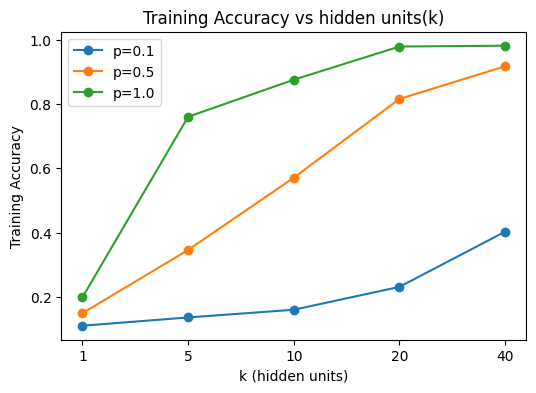

In [12]:
plt.figure(figsize=(6, 4))
for x in dropout_prob_list:
    train_accuracy = []
    for result in results:
        if result['dropout_probability'] == x:
            hidden_units.append(result['hidden_units'])
            train_accuracy.append(result['train_accuracy'][-1])
    plt.plot(train_accuracy, label=f"p={x}", marker='o')
plt.xticks(np.arange(len(hidden_units_list)), hidden_units_list)
plt.legend(loc='best')
plt.xlabel("k (hidden units)")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs hidden units(k)")
plt.show()
    

**What is the role of p on training accuracy? When p is smaller, is it easier to optimize or more difficult? For each choice of p, determine at what choice of k, training accuracy becomes 100%.** 

Here, p determines the probability of keeping the hidden nodes as it is. Lower value of p means, there is high chances of the hidden nodes to become 0 (dropped) and, higher value of p means we are not dropping any hidden node. If we introduce more dropout (low value of p), the training will become more generic. It will impose regularization on the model and it will take time to optimize. However, in that case, the performance on unknown data may be better. 

For the choice of p=1.0 and k=20 I could get close to 100% training accuracy. For k=40 also gives similar performance. 



#### 2. c) Plot the test accuracy as a function of k and for different p ∈ P on the same plot. 

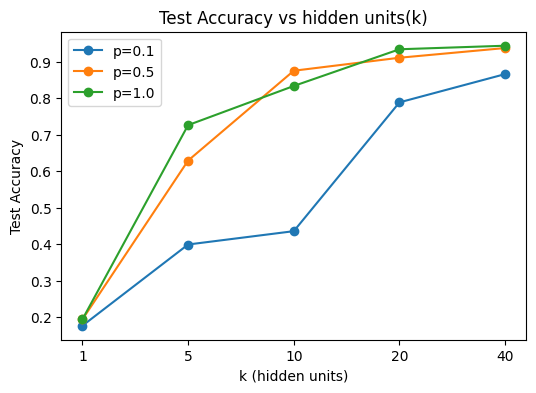

In [13]:
plt.figure(figsize=(6, 4))
for x in dropout_prob_list:
    test_accuracy = []
    for result in results:
        if result['dropout_probability'] == x:
            hidden_units.append(result['hidden_units'])
            test_accuracy.append(result['test_accuracy'][-1]) 
    plt.plot(test_accuracy, label=f"p={x}", marker='o')
plt.xticks(np.arange(len(hidden_units_list)), hidden_units_list)
plt.legend(loc='best')
plt.xlabel("k (hidden units)")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs hidden units(k)")
plt.show() 

**Does dropout help with the test accuracy? For which (k,p) configuration do you achieve the best test accuracy?** 

Yes. Dropout helps to improve test accuracy. We see that, p=0.5 improves the test accuracy as k increases in a more smooth way than p=1.0. 

For (40, 0.5) I got 93.7% test accuracy, and for (40, 1.0) I got 94.4% accuracy. However, for p=0.5, the performance could be better if we continue for more epochs. 

#### 3. (7 pts) We will spice up the problem by adding some noise to labels. Pick 40% of the training examples at random. Assign their labels at random to another value from 0 to 9. For instance, if the original image is 0 and its label is 0, then you will assign its label to a number from 1 to 9 at random. Thus 60% of the training examples remain correct and 40% will have incorrect labels. Repeat the previous step with this noisy dataset. 

In [14]:
train_labels_2 = train_labels.copy()

In [15]:
num_examples = int(len(train_labels) * 0.4) 
print(num_examples) 
selected_indices = np.random.choice(len(train_labels), size=num_examples, replace=False) 
train_labels_2[selected_indices]

4000


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
for idx in selected_indices:
    current_encoding = train_labels_2[idx]
    other_indices = np.where(current_encoding == 0)[0]
    new_position = np.random.choice(other_indices)
    current_encoding[:] = 0
    current_encoding[new_position] = 1 



In [17]:
train_labels_2[selected_indices]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
train_dataset2 = TensorDataset(torch.from_numpy(train_images), torch.from_numpy(train_labels_2)) 
test_dataset2 = TensorDataset(torch.from_numpy(test_images), torch.from_numpy(test_labels)) 

train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=64, shuffle=True)
test_loader2 = torch.utils.data.DataLoader(test_dataset2, batch_size=64, shuffle=False) 

In [21]:
results = []

for hidden_units in hidden_units_list:
    for dropout_prob in dropout_prob_list:
        print(f"Hidden Units: {hidden_units}, Dropout Prob: {dropout_prob} => ") 
        model = ShallowNeuralNetwork(input_size, output_size, hidden_units, dropout_prob)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 80
        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []
        for epoch in range(num_epochs):
            # Training
            train_loss, train_accuracy = train(model, train_loader2, criterion, optimizer, device)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            # Testing
            test_loss, test_accuracy = test(model, test_loader2, criterion, device)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)
            print(f"({hidden_units}, {dropout_prob}) Epoch:{epoch}/{num_epochs}, train_loss:{train_loss:0.4f}, train_acc:{train_accuracy:0.3f}, test_loss:{test_loss:0.4f}, test_acc:{test_accuracy:0.3f}")
        
        result = {
            'hidden_units': hidden_units,
            'dropout_probability': dropout_prob,
            'train_loss': train_losses,
            'train_accuracy': train_accuracies,
            'test_loss': test_losses,
            'test_accuracy': test_accuracies 
        }
        results.append(result)
        

Hidden Units: 1, Dropout Prob: 0.1 => 
(1, 0.1) Epoch:0/80, train_loss:2.3011, train_acc:0.101, test_loss:2.2550, test_acc:0.098
(1, 0.1) Epoch:1/80, train_loss:2.2997, train_acc:0.101, test_loss:2.2825, test_acc:0.098
(1, 0.1) Epoch:2/80, train_loss:2.2993, train_acc:0.101, test_loss:2.2516, test_acc:0.098
(1, 0.1) Epoch:3/80, train_loss:2.2984, train_acc:0.101, test_loss:2.2667, test_acc:0.098
(1, 0.1) Epoch:4/80, train_loss:2.2988, train_acc:0.101, test_loss:2.2599, test_acc:0.098
(1, 0.1) Epoch:5/80, train_loss:2.2996, train_acc:0.101, test_loss:2.2669, test_acc:0.098
(1, 0.1) Epoch:6/80, train_loss:2.2994, train_acc:0.101, test_loss:2.2534, test_acc:0.098
(1, 0.1) Epoch:7/80, train_loss:2.2986, train_acc:0.101, test_loss:2.2615, test_acc:0.098
(1, 0.1) Epoch:8/80, train_loss:2.2972, train_acc:0.101, test_loss:2.2501, test_acc:0.098
(1, 0.1) Epoch:9/80, train_loss:2.2985, train_acc:0.101, test_loss:2.2716, test_acc:0.098
(1, 0.1) Epoch:10/80, train_loss:2.2986, train_acc:0.101, tes

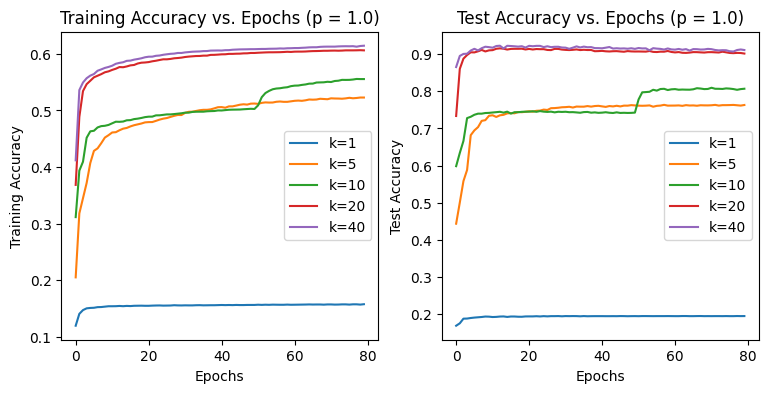

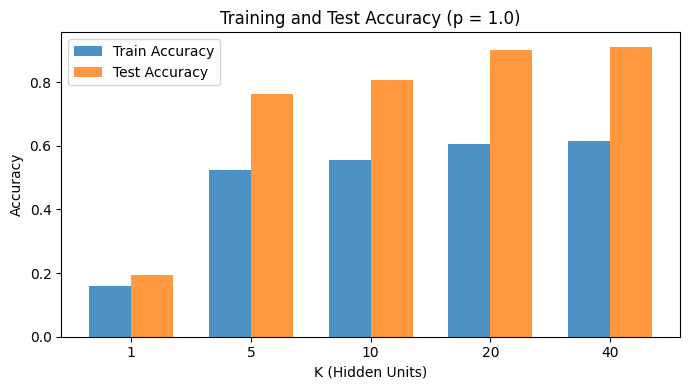

In [22]:
plt.figure(figsize=(9, 4))
a=plt.subplot(121)
for result in results:
    if result['dropout_probability'] == 1.0:
        #print(result['hidden_units'], result['train_accuracy'][-1])
        a.plot(result['train_accuracy'], label=f"k={result['hidden_units']}")

a.set_xlabel('Epochs')
a.set_ylabel('Training Accuracy')
a.set_title('Training Accuracy vs. Epochs (p = 1.0)')
a.legend()

b=plt.subplot(122)
for result in results:
    if result['dropout_probability'] == 1.0:
        #print(result['hidden_units'], result['test_accuracy'][-1])
        b.plot(result['test_accuracy'], label=f"k={result['hidden_units']}")

b.set_xlabel('Epochs')
b.set_ylabel('Test Accuracy')
b.set_title('Test Accuracy vs. Epochs (p = 1.0)')
b.legend()

plt.show() 


plt.figure(figsize=(7, 4))
bar_width = 0.35
opacity = 0.8

hidden_units = []
train_accuracy = []
test_accuracy = []

for result in results:
    if result['dropout_probability'] == 1.0:
        hidden_units.append(result['hidden_units'])
        train_accuracy.append(result['train_accuracy'][-1])
        test_accuracy.append(result['test_accuracy'][-1])

x = np.arange(len(hidden_units))

plt.bar(x - bar_width/2, train_accuracy, bar_width, alpha=opacity, label='Train Accuracy')
plt.bar(x + bar_width/2, test_accuracy, bar_width, alpha=opacity, label='Test Accuracy')

plt.xlabel('K (Hidden Units)')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy (p = 1.0)')
plt.xticks(x, hidden_units)  # Set the x-axis ticks to hidden_units
plt.legend(loc='best')
plt.tight_layout()
plt.show()

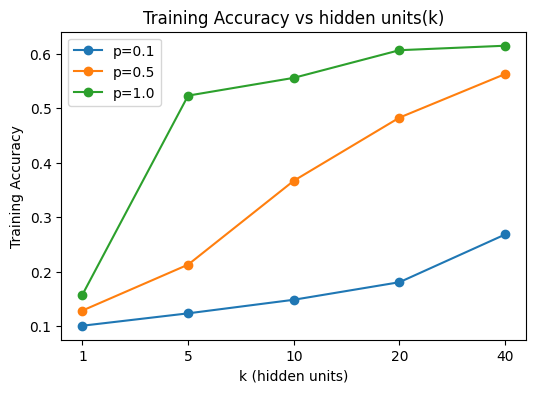

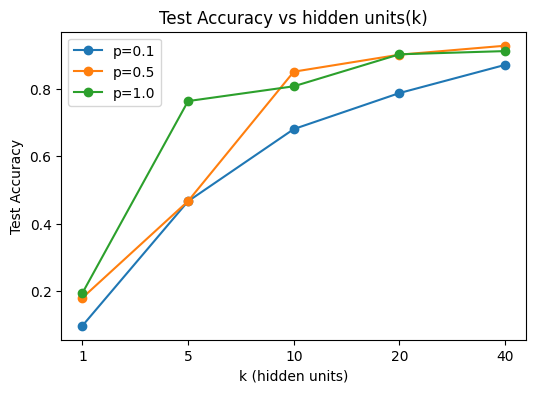

In [23]:
plt.figure(figsize=(6, 4))
for x in dropout_prob_list:
    train_accuracy = []
    for result in results:
        if result['dropout_probability'] == x:
            hidden_units.append(result['hidden_units'])
            train_accuracy.append(result['train_accuracy'][-1])
    plt.plot(train_accuracy, label=f"p={x}", marker='o')
plt.xticks(np.arange(len(hidden_units_list)), hidden_units_list)
plt.legend(loc='best')
plt.xlabel("k (hidden units)")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs hidden units(k)")
plt.show()



plt.figure(figsize=(6, 4))
for x in dropout_prob_list:
    test_accuracy = []
    for result in results:
        if result['dropout_probability'] == x:
            hidden_units.append(result['hidden_units'])
            test_accuracy.append(result['test_accuracy'][-1]) 
    plt.plot(test_accuracy, label=f"p={x}", marker='o')
plt.xticks(np.arange(len(hidden_units_list)), hidden_units_list)
plt.legend(loc='best')
plt.xlabel("k (hidden units)")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs hidden units(k)")
plt.show()

#### 4. (3 pts) Comment on the differences between Step 2 and Step 3. How does noise change things? For which setup dropout is more useful? 

Step-2 has correct train labels and Step-3 has 40% noisy train labels. And we experimented whether the inclusion of dropout will have impact in learning process for the changed scenario. Noise makes it difficult for the model to learn the patterns associated with labels. 

In the case, when 40% of training data has noisy labels, dropout improves the test performance. We can see that, p=0.5 improves test accuracy as the value of k increases in a non-decreasing manner. Interestingly, p=0.1 improves test performance drastically than the previous experiment. And, adding more hidden units in this setting may give the best performance. It proves that, if our dataset has noisy labels in training, introducing dropout will improve the model performance on test data. 